# Import Modules

In [1]:
import os
import json 
import gzip

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string

# Get the dataset (Amazon Video Game Reviews)

In [2]:
#!curl https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz -o games.tsv.gz
#!gzip -d games.tsv.gz

# Load into Pandas DataFrame 

There are a small number of lines in this file that don't parse properly

In [3]:
games = pd.read_csv('games.tsv', delimiter = '\t',error_bad_lines=False)

b'Skipping line 20630: expected 15 fields, saw 22\nSkipping line 28172: expected 15 fields, saw 22\nSkipping line 54791: expected 15 fields, saw 22\n'
b'Skipping line 75419: expected 15 fields, saw 22\nSkipping line 104832: expected 15 fields, saw 22\n'
b'Skipping line 138464: expected 15 fields, saw 22\nSkipping line 194849: expected 15 fields, saw 22\n'
b'Skipping line 201568: expected 15 fields, saw 22\nSkipping line 242567: expected 15 fields, saw 22\n'
b'Skipping line 493585: expected 15 fields, saw 22\nSkipping line 502478: expected 15 fields, saw 22\n'
b'Skipping line 660750: expected 15 fields, saw 22\n'


# Examine Data

In [4]:
games.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31


In [5]:
games.dtypes

marketplace          object
customer_id           int64
review_id            object
product_id           object
product_parent        int64
product_title        object
product_category     object
star_rating           int64
helpful_votes         int64
total_votes           int64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
dtype: object

The data types all seem to be correct

In [6]:
games.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,1.780268e+06,1.780268e+06,1.780268e+06,1.780268e+06,1.780268e+06
mean,2.803021e+07,4.954251e+08,4.059375e+00,2.263971e+00,3.764128e+00
std,1.562851e+07,2.909145e+08,1.355964e+00,1.919211e+01,2.247177e+01
min,1.001800e+04,3.140000e+03,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.429715e+07,2.452708e+08,4.000000e+00,0.000000e+00,0.000000e+00
50%,2.732141e+07,4.920909e+08,5.000000e+00,0.000000e+00,1.000000e+00
75%,4.274834e+07,7.485890e+08,5.000000e+00,1.000000e+00,3.000000e+00
max,5.309656e+07,9.999685e+08,5.000000e+00,1.049800e+04,1.078000e+04


In [7]:
games.star_rating.value_counts()

5    1023167
4     317460
1     191633
3     153451
2      94557
Name: star_rating, dtype: int64

Star ratings tend to be fairly high on average with a mean of 4, most reviews have no helpful_votes but some reviews have a lot of helpful votes

In [8]:
games.isna().sum()

marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title         0
product_category      0
star_rating           0
helpful_votes         0
total_votes           0
vine                  0
verified_purchase     0
review_headline      28
review_body          59
review_date          27
dtype: int64

There are a very small number of NA values, they make up less than .01% of the data so dropping those rows should not have a substantial impact

In [9]:
games.dropna(inplace=True)

In [10]:
games.isna().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
dtype: int64

In order to get everything the customer wrote for the review, we are combining the 'review_headline' and 'review_body'. There are, however, a large number of reviews where the review headline is just a restatement of the star rating, this is information that is already captured elsewhere so those headlines are being ignored. 

In [11]:
games['review_full'] = np.where(games['review_headline'].str.lower().str.contains('star'), games['review_body'], 
                                games['review_headline'] + ' '+ games['review_body'])

In [12]:
games.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_full
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31,an amazing joystick. I especially love that yo...
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31,Definitely a silent mouse... Not a single clic...
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31,poor quality work and not as it is advertised.
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31,"good, but could be bettee nice, but tend to sl..."
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31,"Great but flawed. Great amiibo, great for coll..."


We are interested in analyzing whether the review was positive or negative, so a new column is being created which classifies a review as positive if it is 4 stars or greater, negative if it is 2 stars or less, and neutral otherwise

In [13]:
games['Sentiment_target'] = np.where(games.star_rating > 3, 'Positive', np.where(games.star_rating < 3, 'Negative', 'Neutral'))

In [14]:
games.Sentiment_target.value_counts()

Positive    1340545
Negative     286166
Neutral      153443
Name: Sentiment_target, dtype: int64

# Preprocessing and visualization

Define a pre-processing function to lemmatize the text and remove stopwords (this takes some time to run)

In [15]:
def preprocess(text):
    words = nltk.tokenize.word_tokenize(text)
           
    lem = nltk.stem.WordNetLemmatizer()
    words = [lem.lemmatize(word) for word in words]
    
    stopwords = nltk.corpus.stopwords.words('english')
    words = [word for word in words if word not in stopwords+['br','wa']+list(string.punctuation)]
   
    return ' '.join(words)

In [16]:
games['review_clean'] = games.review_full.apply(preprocess)
games.sample(10)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_full,Sentiment_target,review_clean
1595802,US,19890146,R2Q6MVDHV7DLA5,B00006C2HA,837770305,Doom 3,Video Games,2,2,4,N,N,R.I.P. action games,"Let's face it, guys: The single-player first p...",2005-02-19,"R.I.P. action games Let's face it, guys: The s...",Negative,R.I.P action game Let 's face guy The single-p...
368206,US,29898516,RBNXOH6NJASC7,B001AHMM8A,593482301,Build-a-lot - Nintendo DS,Video Games,5,0,0,N,Y,Five Stars,"Great game, I enjoyed it very much",2014-12-11,"Great game, I enjoyed it very much",Positive,Great game I enjoyed much
1602441,US,50288580,R25WCG7CSQTLJV,B0000ALSFV,722651749,Full Spectrum Warrior,Video Games,2,2,3,N,N,"Great on tactics, no fun on gameplay","Well, the game graphics are great, the sound a...",2004-11-27,"Great on tactics, no fun on gameplay Well, the...",Negative,Great tactic fun gameplay Well game graphic gr...
302117,US,12119323,R3T0TEJ0284VE7,B00DS0MQUQ,764259954,Battlefield 4,Video Games,3,1,1,N,Y,Kinda buggy at times,"It a good game, a little buggy at times! I did...",2015-01-12,"Kinda buggy at times It a good game, a little ...",Neutral,Kinda buggy time It good game little buggy tim...
1184687,US,52281467,R3B41JKMX7WESQ,B000R0SS3Y,71281677,Too Human - Xbox 360,Video Games,1,4,5,N,N,Best looking worst game ever.,"This game looks great, but plays TERRIBLE.<br ...",2011-11-22,Best looking worst game ever. This game looks ...,Negative,Best looking worst game ever This game look gr...
466276,US,49620639,R3G8MY8H3DMY9Z,B00JC5Y9LK,909629619,Turtle Beach - Ear Force PlayStation 4 Upgrade...,Video Games,4,0,0,Y,N,Used to upgrade Turtle Beach headphones to PS4,We used this for my Turtle Beach headphones to...,2014-09-21,Used to upgrade Turtle Beach headphones to PS4...,Positive,Used upgrade Turtle Beach headphone PS4 We use...
68217,US,6858830,R2BQK1EYSWFCT8,B003O6E800,970259291,The Legend of Zelda: Ocarina of Time 3D,Video Games,5,0,0,N,Y,Five Stars,Best thing I bought in awhile,2015-07-03,Best thing I bought in awhile,Positive,Best thing I bought awhile
1002063,US,14774623,R30ID3IC4RA4EQ,B00A878J5I,19953901,Energizer 3x Charge Station for Wii U,Video Games,5,0,0,N,Y,Gift for my son,My son bought a WiiU for himself right after T...,2013-01-10,Gift for my son My son bought a WiiU for himse...,Positive,Gift son My son bought WiiU right Thanksgiving...
1149136,US,9913638,R168KIIAYVJ3DE,B0049DYNNO,528483553,Super Mario All-Stars: Limited Edition,Video Games,5,0,0,N,Y,Super Mario All-Stars Limited Edition,Whats old is new! If you love Mario/Luigi then...,2012-02-02,Whats old is new! If you love Mario/Luigi then...,Positive,Whats old new If love Mario/Luigi got Limited ...
121280,US,32603122,R3F4K4ATLGU9E9,B00AAQRNQ8,807565333,Anker 8200 DPI High Precision Programmable Las...,Video Games,5,0,0,N,Y,Five Stars,Amazing for the price,2015-05-14,Amazing for the price,Positive,Amazing price


In [17]:
from wordcloud import WordCloud

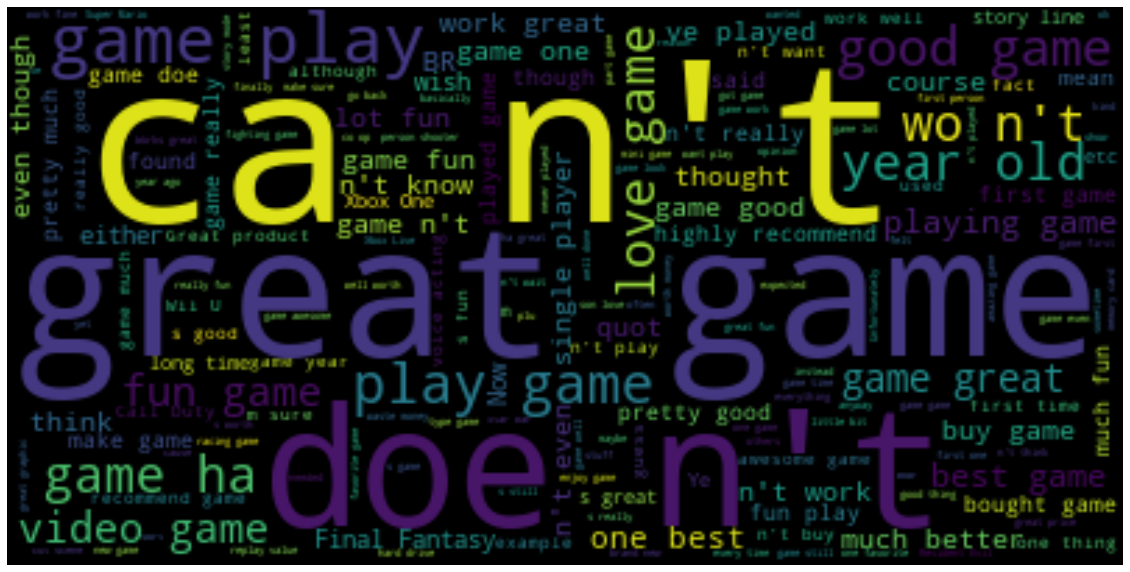

In [18]:
full_text = ' '.join(games.review_clean)
wordcloud = WordCloud().generate(full_text)

plt.rcParams["figure.figsize"] = (20,15)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This is a word cloud showing word frequency across all reviews. The most frequent words here definitely trend towards the positive side with 'great' showing up frequently, this could be because over 50% of all of the reviews are 5 star reviews, and the vast majority of reviews are positive.

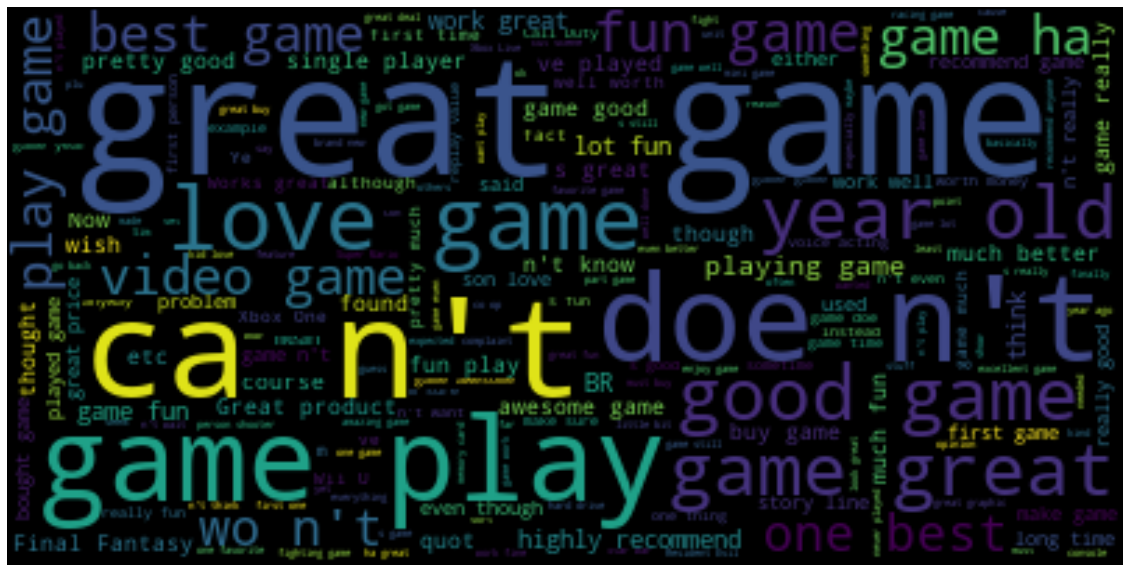

In [19]:
full_text = ' '.join(games.review_clean[games.Sentiment_target=='Positive'])
wordcloud = WordCloud().generate(full_text)

plt.rcParams["figure.figsize"] = (20,15)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This is a word cloud showing word frequency is positive reviews.It looks very similar tothe word cloud showing all reviews, but words expressing positive sentiment like 'good', 'great', and 'love' are more common. 

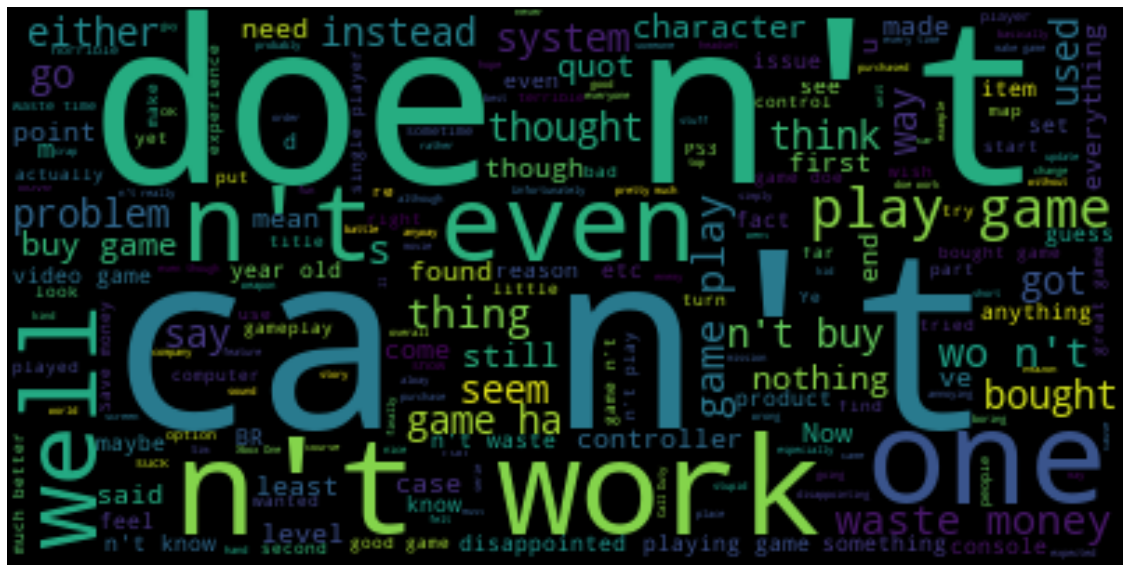

In [20]:
full_text = ' '.join(games.review_clean[games.Sentiment_target=='Negative'])
wordcloud = WordCloud().generate(full_text)

plt.rcParams["figure.figsize"] = (20,15)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This is a word cloud showing word frequency in negative reviews. Negative sentiment is not as prevalent here as positive sentiment was in the positive reviews, but some words like 'disappointed' and 'waste' do show up.

# Set up NLP [RAJA BROKEN]

In [21]:
# import nltk
# nltk.download('stopwords') 
# nltk.download('wordnet')

# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import RegexpTokenizer
# from nltk.corpus import stopwords
# from sklearn.feature_extraction.text import TfidfVectorizer

# def preprocess_text(text):
#     # Tokenise words while ignoring punctuation
#     tokeniser = RegexpTokenizer(r'\w+')
#     tokens = tokeniser.tokenize(text)

#     # Lowercase and lemmatise 
#     lemmatiser = WordNetLemmatizer()
#     lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]

#     # Remove stopwords
#     keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
#     return keywords


# X_train = video_game_data[['reviewText']]

# vectoriser = TfidfVectorizer(analyzer=preprocess_text)
# # Fit to the data and transform to feature matrix
# X_train = vectoriser.fit_transform(X_train['reviewText'])
# # Convert sparse matrix to dataframe
# X_train = pd.DataFrame.sparse.from_spmatrix(X_train)
# # Save mapping on which index refers to which words
# col_map = {v:k for k, v in vectoriser.vocabulary_.items()}
# # Rename each column using the mapping
# for col in X_train.columns:
#     X_train.rename(columns={col: col_map[col]}, inplace=True)
# X_train



## Tensorflow NLP

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import model_from_json
import re
import warnings 
warnings.filterwarnings('ignore')
from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

In [23]:
# !curl https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz -o games.tsv.gz
# !gzip -d games.tsv

In [24]:
games = pd.read_csv('amazon_reviews_us_Video_Games_v1_00.tsv', sep='\t', error_bad_lines=False)

FileNotFoundError: [Errno 2] File amazon_reviews_us_Video_Games_v1_00.tsv does not exist: 'amazon_reviews_us_Video_Games_v1_00.tsv'

In [ ]:
games.columns

In [ ]:
games.info()

In [ ]:
games.describe()

In [ ]:
games.duplicated().sum()

In [ ]:
games.head(5)

In [ ]:
len(games)

In [ ]:
games.iloc[0:20].review_headline

In [ ]:
games.iloc[0:5].review_body

In [ ]:
games = games[['review_body','star_rating']]

In [ ]:
games

In [ ]:
row_select_1 = games['star_rating'] < 3
row_select_2 = games['star_rating'] == 3
games['sentiment'] = pd.Series(['Positive']*len(games.index))
games.loc[row_select_1,'sentiment'] = 'Negative'
games.loc[row_select_2,'sentiment'] = 'Neutral'

In [ ]:
games = games[['review_body','sentiment']]
games.columns = ['text', 'sentiment']

In [ ]:
games

In [ ]:
# Embedding
max_features = 20000
maxlen = 100
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 2

In [ ]:
games = games[games.sentiment != "Neutral"]
games['text'] = games['text'].apply(lambda x: str(x).lower())
games['text'] = games['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(games[ games['sentiment'] == 'Positive'].size)
print(games[ games['sentiment'] == 'Negative'].size)

for idx,row in games.iterrows():
    row[0] = row[0].replace('rt',' ')
    
tokenizer = Tokenizer(nb_words = max_features, split=' ')
tokenizer.fit_on_texts(games['text'].values)
X = tokenizer.texts_to_sequences(games['text'].values)
X = pad_sequences(X, maxlen = maxlen)

In [ ]:
Y = pd.get_dummies(games['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

In [ ]:
print('Build model...')

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

In [ ]:
print('Train...')
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,shuffle=True, validation_data=(X_test, Y_test))

In [ ]:
yhat = model.predict(X_test, verbose = 2, batch_size = batch_size)
from sklearn import metrics
print(metrics.classification_report(Y_test[:,1], np.round(yhat[:,1]) ,target_names = ["negative", "positive"]))

In [ ]:
score = ['negative', 'positive']

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greys):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(score)))
    plt.xticks(tick_marks, score, rotation=45)
    plt.yticks(tick_marks, score)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(Y_test[:,1], np.round(yhat[:,1]))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

.

### Citation For data:
    
Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019